<a href="https://colab.research.google.com/github/Valeriia37/Real-estate-price-prediction/blob/main/real_estate_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center> Real estate price prediction</center>
##<center> Project work.</center>

In this competition the task will be to predict the price of flats in test.csv. I will be given two datasets: train.csv (contains all features and prices of flats) and test.csv (only features).

# Table of Contents
<a id="toc"></a>
* [1. Imports](#1)
* [2. Data Loading and Preperation](#2)
    - [2.1 Exploring Train Data](#2.1)
    - [2.2 Exploring Test Data](#2.2)
    - [2.3 Submission File](#2.3)
* [3. EDA](#3)
    - [3.1 Overview of Data](#3.1)
    - [3.2 Null Value Distribution](#3.7)
    - [3.3 Continuos and Categorical Data Distribution](#3.2)
    - [3.4 Feature Distribution of Continous Features](#3.3)
    - [3.5 Feature Distribution of Categorical Features](#3.4)
    - [3.6 Target Distribution ](#3.5)
    - [3.7 Correlation Matrix ](#3.6)
* [4. Data Pre-Processing](#4)
    - [4.1 Fix outliers](#4.1)
    - [4.2 Fix nan](#4.2)
* [5. Generate new features](#5)
    - [5.1 New features](#5.1)
    - [5.2 Dimension reduction](#5.2)
* [6. Feature selection](#6)
* [7. Split dataset on train and test](#7)
* [8. Modeling](#8)
    - [8.1 LAZY PREDICT](#8.1)
    - [8.2 LGBM Regressor](#8.2)
* [9. Clusterization](#9)
    - [9.1 AgglomerativeClustering](#9.1)
    - [9.2 Modeling and comparing](#9.2)
* [10. Prediction and submission](#10)

# **<center>Imports</center>**<a class='anchor' id='1'>

**Installing LazyPredict**

In [ ]:
from IPython.display import clear_output
!pip install -U lazypredict
!pip install -U pandas #Upgrading pandas

clear_output()

**Installing Lightgbm**

In [ ]:
!pip install lightgbm
clear_output()

**Libraries import**

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random

from datetime import datetime
from scipy.spatial.distance import cdist

from sklearn.preprocessing import StandardScaler, RobustScaler

# Models
from lazypredict.Supervised import LazyRegressor
import lazypredict
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

# Clusterization
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Dimensions reduce
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

# Vizualization of data
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
matplotlib.rcParams.update({'font.size': 14})

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Functions**

In [ ]:
# Function of prediction evaluation
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# function of reducing dimensions
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Method is wrong'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()
    

def apply_elbow_method(X):
    """'The Elbow' method visualization"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    

def display_clusters_distribution(unique_labels, labels_counts):
    """Visualization of the distribution of classes by clusters"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# <center> Data Loading and Preperation </center> <a class='anchor' id='2'>

 **File descriptions**


1.   train.csv - the training set
2.   test.csv - the test set
3. sampleSubmission.csv - a sample submission file in the correct format


**Dataset paths**

In [ ]:
DATASET_PATH = '/gdrive/My Drive/Colab Notebooks/train.csv'
DATASET_PATH_TEST = '/gdrive/My Drive/Colab Notebooks/test.csv'
DATASET_SUBMISSION = '/gdrive/My Drive/Colab Notebooks/sample_submission.csv'

**Data loading**

In [ ]:
train_df = pd.read_csv(DATASET_PATH, sep=',')
test_df = pd.read_csv(DATASET_PATH_TEST, sep=',')
submit = pd.read_csv(DATASET_SUBMISSION, sep=',')

# Average percentage of life square of the total square by years
Life_Square_DATASET_PATH = '/gdrive/My Drive/Files/ProcentOfLifeSquare.csv'
proc = pd.read_csv(Life_Square_DATASET_PATH, sep=';')

In [ ]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Dataset description**

* **Id** - apartment identification number
* **DistrictId** - district identification number
* **Rooms** - number of rooms
* **Square** - total square
* **LifeSquare** - life square
* **KitchenSquare** - kitchen square
* **Floor** - apartment floor
* **HouseFloor** - number of floors in the house
* **HouseYear** - year when the house was built
* **Ecology_1, Ecology_2, Ecology_3** - environmental indicators of the area
* **Social_1, Social_2, Social_3** - social indicators of the area
* **Healthcare_1, Helthcare_2** - indicators of the area related to health protection
* **Shops_1, Shops_2** - indicators related to the presence of shops, shopping centers
* **Price** - apartment price

In [ ]:
print('Rows in train:', train_df.shape[0])
print('Rows in test', test_df.shape[0])

Rows in train: 10000
Rows in test 5000


##  Exploring Train Data : <a class='anchor' id='2.1'>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
<b><u>Observations in Train Data:</u></b><br>
 
* <i> There are total of <b><u>20</u></b> columns and <b><u>10000</u></b> rows in <b><u>train</u></b> data.</i><br>
* <i> Train data contains <b><u>193089</u></b> observation with <b><u>6911</u></b>  missing values.</i><br>
* <i> Only 2 feature columns have missing values in them with <b><u>Healthcare_1</u></b> having highest missing values <u>(4798 - 48%)</u>  </i><br>
* <i> <b><u>Price</u></b> is the target variable which is only available in the <b><u>train</u></b> dataset.</i><br>
</div>

In [ ]:
print(f'Number of rows in train data: {train_df.shape[0]}')
print(f'Number of columns in train data: {train_df.shape[1]}')
print(f'Number of values in train data: {train_df.count().sum()}')
print(f'Number of missing values in train data: {sum(train_df.isna().sum())}')

Number of rows in train data: 10000
Number of columns in train data: 20
Number of values in train data: 193089
Number of missing values in train data: 6911


In [ ]:
print(train_df.isna().sum().sort_values(ascending = False))

Healthcare_1     4798
LifeSquare       2113
Id                  0
Ecology_3           0
Shops_2             0
Shops_1             0
Helthcare_2         0
Social_3            0
Social_2            0
Social_1            0
Ecology_2           0
DistrictId          0
Ecology_1           0
HouseYear           0
HouseFloor          0
Floor               0
KitchenSquare       0
Square              0
Rooms               0
Price               0
dtype: int64


In [ ]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00,10000.00,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,8383.41,50.40,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,4859.02,43.59,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,0.00,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,4169.50,20.00,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,8394.50,36.00,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.64
75%,12592.50,75.00,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,16798.00,209.00,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.47


## Exploring Test Data: <a class='anchor' id='2.2'>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
<b><u>Observations in Test Data:</u></b><br>
 
* <i> There are total of <b><u>19</u></b> columns and <b><u>5000</u></b> rows in <b><u>test</u></b> data.</i><br>
* <i> Test data contains <b><u>91582</u></b> observation with <b><u>3418</u></b>  missing values.</i><br>
* <i> <b><u>Healthcare_1</u></b> have highest missing values <u>(2377)</u>  </i><br>
</div>

In [ ]:
print(f'Number of rows in test data: {test_df.shape[0]}')
print(f'Number of columns in test data: {test_df.shape[1]}')
print(f'Number of values in train data: {test_df.count().sum()}')
print(f'Number of rows with missing values  in test data: {sum(test_df.isna().sum())}')

Number of rows in test data: 5000
Number of columns in test data: 19
Number of values in train data: 91582
Number of rows with missing values  in test data: 3418


In [ ]:
print((test_df.isna().sum().sort_values(ascending = False)))

Healthcare_1     2377
LifeSquare       1041
Id                  0
Ecology_2           0
Shops_1             0
Helthcare_2         0
Social_3            0
Social_2            0
Social_1            0
Ecology_3           0
Ecology_1           0
DistrictId          0
HouseYear           0
HouseFloor          0
Floor               0
KitchenSquare       0
Square              0
Rooms               0
Shops_2             0
dtype: int64


In [ ]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00,5000.00,5000.00,5000.00,3959.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,2623.00,5000.00,5000.00
mean,8412.60,51.28,1.91,56.45,36.16,5.98,8.63,12.60,1984.39,0.12,24.93,5406.90,8.26,1146.66,1.32,4.24
std,4832.67,44.18,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,4026.61,23.86,1044.74,1.48,4.78
min,1.00,0.00,0.00,1.38,0.33,0.00,1.00,0.00,1908.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,4221.75,21.00,1.00,41.91,23.09,1.00,4.00,9.00,1973.00,0.02,6.00,1564.00,0.00,325.00,0.00,1.00
50%,8320.50,37.00,2.00,52.92,32.93,6.00,7.00,12.00,1977.00,0.07,25.00,5285.00,2.00,900.00,1.00,3.00
75%,12598.25,77.00,2.00,66.29,45.17,9.00,12.00,17.00,2000.00,0.20,36.00,7287.00,5.00,1548.00,2.00,6.00
max,16795.00,212.00,17.00,223.45,303.07,620.00,78.00,99.00,2020.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00


## Submission File  <a class='anchor' id='2.3'>

In [ ]:
submit.head()

,Id,Price
0,4567,200000.00
1,5925,200000.00
2,960,200000.00
3,3848,200000.00
4,746,200000.00


**Cast Id and DistrictId to string type**

In [ ]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [ ]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#<center> EDA </center>  <a class='anchor' id='eda'>

**Target**

In [ ]:
TARGET = 'Price'
FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]

## Overview of Data <a class='anchor' id='3.1'>

In [ ]:
train_df.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
HouseYear,10000.00,3990.17,200500.26,1910.00,1974.00,1977.00,2001.00,20052011.00
Social_2,10000.00,5352.16,4006.80,168.00,1564.00,5285.00,7227.00,19083.00
Healthcare_1,5202.00,1142.90,1021.52,0.00,350.00,900.00,1548.00,4849.00
LifeSquare,7887.00,37.20,86.24,0.37,22.77,32.78,45.13,7480.59
KitchenSquare,10000.00,6.27,28.56,0.00,1.00,6.00,9.00,2014.00
Social_3,10000.00,8.04,23.83,0.00,0.00,2.00,5.00,141.00
Square,10000.00,56.32,21.06,1.14,41.77,52.51,65.90,641.07
Social_1,10000.00,24.69,17.53,0.00,6.00,25.00,36.00,74.00
HouseFloor,10000.00,12.61,6.78,0.00,9.00,13.00,17.00,117.00
Floor,10000.00,8.53,5.24,1.00,4.00,7.00,12.00,42.00


## Null Value Distribution <a class='anchor' id='3.2'>

In [ ]:
test_null = pd.DataFrame(test_df.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train_df.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

## Continuos and Categorical Data Distribution <a class='anchor' id='3.3'>

In [ ]:
text_features = train_df.select_dtypes(include='object').columns.tolist()
cat_features = ['Rooms', 'Floor', 'HouseFloor', 'HouseYear']
cont_features = [col for col in FEATURES if col not in cat_features and col not in text_features]

print(f'Total number of features: {len(FEATURES)}')
print(f'Number of categorical features: {len(cat_features)}')
print(f'Number of continuos features: {len(cont_features)}')
print(f'Number of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Total number of features: 19
Number of categorical features: 4
Number of continuos features: 10
Number of text features: 5


## Feature Distribution of Continous Features <a class='anchor' id='3.4'>

**Distribution of Square**

In [ ]:
train_square = train_df.copy()
test_square = test_df.copy()
train_square["type"] = "Train"
test_square["type"] = "Test"
squareDf = pd.concat([train_square, test_square])
fig = px.histogram(data_frame = squareDf, 
                   x="Square",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 200,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Square" , title_x = 0.5)
fig.show()

## Feature Distribution of Categorical Features <a class='anchor' id='3.5'>

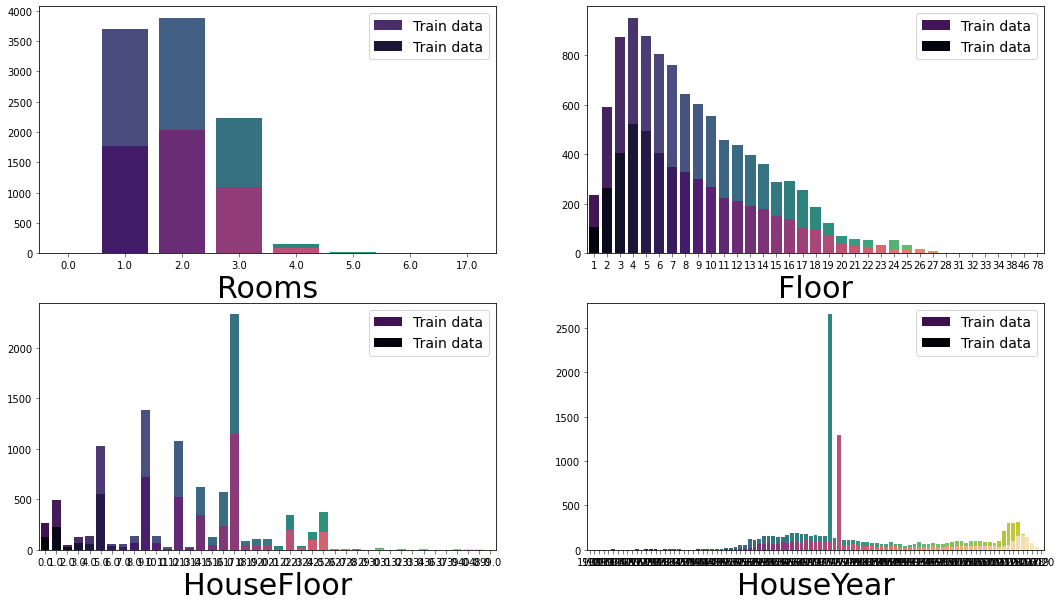

In [ ]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train_df[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test_df[col],ax = axes[r,c] ,palette = "magma", label='Train data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=30)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

## Target Distribution <a class='anchor' id='3.6'>

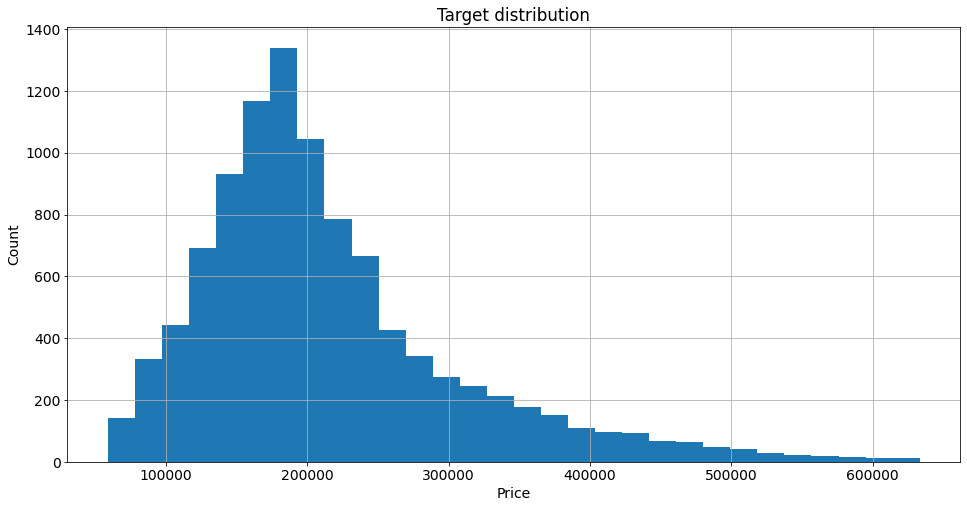

In [ ]:
plt.figure(figsize = (16, 8))

train_df[TARGET].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## Correlation matrix <a class='anchor' id='3.7'>

In [ ]:
fig = px.imshow(train_df.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

#<center>Data Pre-Processing</center> <a class='anchor' id='4'>

### Fix outliers <a class='anchor' id='4.1'>

**HouseYear**

In [ ]:
train_df.HouseYear.sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [ ]:
# Outliers - values in excess of 2020
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
# Replacing them with 2020
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

**HouseFloor_outlier**

In [ ]:
train_df.HouseFloor.sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [ ]:
# In Moscow, the highest residential building does not exceed 48 floors
# In Soviet times, the highest building did not exceed 32 floors
# 0 floor is considered as outlier
train_df['HouseFloor_outlier'] = 0
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor']< train_df['Floor']), \
             'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > 48, 'HouseFloor_outlier'] = 1
train_df.loc[(train_df['HouseYear'] < 1991) & (train_df['HouseFloor'] > 32), 'HouseFloor_outlier'] = 1

In [ ]:
# Create a median for the number of floors by year and district
house_floor_per_dist = round(train_df.groupby('DistrictId', as_index=False).agg({'HouseFloor':'median'})\
                        .rename(columns={'HouseFloor': 'med_house_floor_per_dist'}))
house_floor_per_year = round(train_df.groupby('HouseYear', as_index=False).agg({'HouseFloor': 'median'})\
                        .rename(columns={'HouseFloor': 'med_house_floor_per_year'}))

In [ ]:
house_floor_per_year

,HouseYear,med_house_floor_per_year
0,1910,9.00
1,1912,8.00
2,1914,6.00
3,1916,6.00
4,1917,5.00
...,...,...
90,2016,17.00
91,2017,17.00
92,2018,17.00
93,2019,17.00


In [ ]:
train_df = train_df.merge(house_floor_per_dist, on='DistrictId', how='left')
train_df = train_df.merge(house_floor_per_year, on='HouseYear', how='left')

In [ ]:
# The main idea is that in the Soviet years houses were built according to five-year plans. 
# Therefore, the similarity between houses built in the same year will be higher 
# than the similarity among buildings in the same area. 
# After the collapse of the Soviet Union, different companies were already engaged 
# in the construction of houses for their plots of land. Therefore, the similarity 
# of houses by district prevailed.
train_df.loc[(train_df['HouseFloor_outlier'] == 1) & (train_df['HouseYear'] <= 1991)\
             & (train_df['Floor'] <= train_df['med_house_floor_per_year']),\
              'HouseFloor'] = train_df['med_house_floor_per_year']
train_df.loc[(train_df['HouseFloor_outlier'] == 1) & (train_df['HouseYear'] <= 1991) \
             & (train_df['Floor'] > train_df['med_house_floor_per_year']), \
             'HouseFloor'] = train_df['Floor']
train_df.loc[(train_df['HouseFloor_outlier'] == 1) & (train_df['HouseYear'] > 1991) \
             & (train_df['Floor'] <= train_df['med_house_floor_per_dist']),\
              'HouseFloor'] = train_df['med_house_floor_per_dist']
train_df.loc[(train_df['HouseFloor_outlier'] == 1) & (train_df['HouseYear'] > 1991) \
             & (train_df['Floor'] > train_df['med_house_floor_per_dist']),\
             'HouseFloor'] = train_df['Floor']

In [ ]:
train_df.HouseFloor.sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 36., 37., 38., 39., 40., 44.,
       45., 47., 48.])

**Floor_outlier**

In [ ]:
train_df.Floor.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [ ]:
# There are no deviations in the resulting spread of values.
# But the floor cannot exceed the house floor
test_df[test_df.HouseFloor < test_df.Floor].head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
11,13270,9,3.00,80.60,NaN,1.00,4,1.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B
12,5250,96,4.00,87.78,54.62,10.00,25,24.00,2014,0.04,B,B,53,14892,4,NaN,1,4,B


In [ ]:
train_df['Floor_outlier'] = 0
train_df.loc[(train_df['Floor'] == 0) | (train_df['Floor'] > 48), 'Floor_outlier'] = 1
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor_outlier'] = 1

In [ ]:
train_df.loc[train_df['Floor_outlier'] == 1, 'Floor'] = train_df['med_house_floor_per_dist']
# Replace with a random value
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))

In [ ]:
(train_df.HouseFloor < train_df.Floor).sum()

0

**Square_outlier**

In [ ]:
train_df.Square.sort_values()

7470     1.14
4496     1.99
9869     2.38
8572     2.60
161      2.95
        ...  
7644   212.93
1906   275.65
7010   409.43
726    604.71
9229   641.07
Name: Square, Length: 10000, dtype: float64

In [ ]:
# Square less than 25 and more than 200 m2 considered an outlier
# The total Square cannot be less than the life square
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square']<25) | (train_df['Square'] < train_df['LifeSquare'])\
             | (train_df['Square'] > 200), 'Square_outlier'] = 1

In [ ]:
# Create medians :
square_per_dist = train_df.groupby('DistrictId', as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_dist'})
square_per_year = train_df.groupby('HouseYear', as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_year'})
square_per_dist_and_rooms = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_dist_and_rooms'})
square_per_year_and_rooms = train_df.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_year_and_rooms'})

In [ ]:
train_df = train_df.merge(square_per_dist, on='DistrictId', how='left')
train_df = train_df.merge(square_per_year, on='HouseYear', how='left')
train_df = train_df.merge(square_per_dist_and_rooms, on=['DistrictId', 'Rooms'], how='left')
train_df = train_df.merge(square_per_year_and_rooms, on=['HouseYear', 'Rooms'], how='left')

In [ ]:
# Average percentage of life square of the total square
train_df = train_df.merge(proc[['HouseYear', 'ProcentOfLifeSquare']], on='HouseYear', how='left')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             10000 non-null  int64  
 1   DistrictId                     10000 non-null  int64  
 2   Rooms                          10000 non-null  float64
 3   Square                         10000 non-null  float64
 4   LifeSquare                     7887 non-null   float64
 5   KitchenSquare                  10000 non-null  float64
 6   Floor                          10000 non-null  float64
 7   HouseFloor                     10000 non-null  float64
 8   HouseYear                      10000 non-null  int64  
 9   Ecology_1                      10000 non-null  float64
 10  Ecology_2                      10000 non-null  object 
 11  Ecology_3                      10000 non-null  object 
 12  Social_1                       10000 non-null  

In [ ]:
# If the square < 2.5, then we replace it either with the value of the life square or with the median by the number of rooms
train_df.loc[(train_df['Square'] < 2.5) & (train_df['LifeSquare'] >= 25) \
             & (train_df['LifeSquare'] < 200), 'Square'] = train_df['LifeSquare']
train_df.loc[(train_df['Square'] < 2.5) & (train_df['LifeSquare'] < 25) & \
             (train_df['HouseYear'] > 1991), 'Square'] = train_df['med_square_per_dist_and_rooms']
train_df.loc[(train_df['Square'] < 2.5) & (train_df['LifeSquare'] < 25) & \
             (train_df['HouseYear'] <= 1991), 'Square'] = train_df['med_square_per_year_and_rooms']

# If the square is between 2.5 and 10, then the dividing point may have been incorrectly set during recording
# Otherwise replaced by life square (if within reasonable limits) or by median
train_df.loc[((train_df['Square'] < 10) & (train_df['Square'] >= 2.5)) & (train_df['Square']*10 > train_df['LifeSquare']), \
             'Square'] = train_df['Square'] * 10
train_df.loc[((train_df['Square'] < 10) & (train_df['Square'] >= 2.5)) & (train_df['LifeSquare'].between(25, 200))\
             , 'Square'] = train_df['LifeSquare']
train_df.loc[((train_df['Square'] < 10) & (train_df['Square'] >= 2.5)) & ((train_df['LifeSquare'] < 25)\
             | (train_df['LifeSquare'] > 200)) & (train_df['HouseYear'] <= 1991), 'Square'] \
                = train_df['med_square_per_year_and_rooms']
train_df.loc[((train_df['Square'] < 10) & (train_df['Square'] >= 2.5)) & ((train_df['LifeSquare'] < 25)\
             | (train_df['LifeSquare'] > 200)) & (train_df['HouseYear'] > 1991), 'Square'] \
                = train_df['med_square_per_dist_and_rooms']

# If the square is between 10 and 25, then we look at the number of rooms and the year of construction
train_df.loc[(train_df['Square'].between(10, 25)) & (train_df['Rooms'] <= 1), 'Square'] = 25
train_df.loc[(train_df['Square'].between(10, 25)) & (train_df['Rooms'] > 1) & (train_df['HouseYear'] <= 1991),\
             'Square'] = train_df['med_square_per_year_and_rooms']
train_df.loc[(train_df['Square'].between(10, 25)) & (train_df['Rooms'] > 1) & (train_df['HouseYear'] > 1991), \
             'Square'] = train_df['med_square_per_dist_and_rooms']

# If the square is less than the life square, then replace it with the median or the value of the life square
train_df.loc[(train_df['Square'] < train_df['LifeSquare']) & (train_df['HouseYear'] > 1991) &\
             (train_df['LifeSquare'] >= train_df['med_square_per_dist_and_rooms']) \
             & (train_df['LifeSquare'] < 200), 'Square'] = train_df['LifeSquare']
train_df.loc[(train_df['Square'] < train_df['LifeSquare']) & (train_df['HouseYear'] <= 1991) &\
             (train_df['LifeSquare'] >= train_df['med_square_per_year_and_rooms']) \
             & (train_df['LifeSquare'] < 200), 'Square'] = train_df['LifeSquare']
train_df.loc[(train_df['Square'] < train_df['LifeSquare']) & (train_df['HouseYear'] > 1991)\
             & (train_df['LifeSquare'] < train_df['med_square_per_dist_and_rooms']), \
             'Square'] = train_df['med_square_per_dist_and_rooms']
train_df.loc[(train_df['Square'] < train_df['LifeSquare']) & (train_df['HouseYear'] <= 1991) \
             & (train_df['LifeSquare'] < train_df['med_square_per_year_and_rooms']), \
              'Square'] = train_df['med_square_per_year_and_rooms']

# If the square exceeds 200 m2 replace it with the median
train_df.loc[(train_df['Square'] > 200) & (train_df['HouseYear'] <= 1991),\
              'Square'] = train_df['med_square_per_year_and_rooms']
train_df.loc[(train_df['Square'] > 200) & (train_df['HouseYear'] > 1991),\
             'Square'] = train_df['med_square_per_dist_and_rooms']

In [ ]:
train_df.Square.sort_values()

3750    25.00
242     25.00
9990    25.00
5596    25.00
6379    25.00
        ...  
8011   186.69
1606   190.86
1906   191.85
9307   198.93
7010   226.29
Name: Square, Length: 10000, dtype: float64

**Rooms_outlier**

In [ ]:
train_df.Rooms.sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10., 19.])

In [ ]:
# There cannot be zero number of rooms. Also, the number of rooms exceeding 5, I consider for outliers
# An apartment of more than 100 m2 should have at least 4 rooms. And the apartment has more than 60 - at least 2 rooms.
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | ((train_df['Square']>100) & (train_df['Rooms'] < 4)),\
             'Rooms_outlier'] = 1
train_df.loc[(train_df['Rooms'] > 5), 'Rooms_outlier'] = 1
train_df.loc[(train_df['Square'] > 60) & (train_df['Rooms'] < 2), 'Rooms_outlier'] = 1

# Studio apartment is unlikely to exceed 60 m2 in square
train_df.loc[(train_df['Rooms'] == 1) & (train_df['Square'] > 60), 'Rooms_outlier'] = 1

In [ ]:
train_df.loc[(train_df['Rooms'] == 1), 'Square'].max()

226.29134147924006

In [ ]:
# Replace the zero value with the corresponding square
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] < 40), 'Rooms'] = 1
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 40) & (train_df['Square'] < 60), 'Rooms'] = 2
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 60) & (train_df['Square'] < 100), 'Rooms'] = 3
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 100) & (train_df['Square'] < 150), 'Rooms'] = 4
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 150), 'Rooms'] = 5

# Apartments with more than 5 rooms are considered outliers, so replace them with 5
train_df.loc[train_df['Rooms'] > 5, 'Rooms'] = 5

# In case of too large values of the square of one-room apartments.
# Since there are no clear square boundaries for a different number of rooms, 
# we replace them with the minimum possible ones, depending on the square
train_df.loc[(train_df['Square'] > 60) & (train_df['Rooms'] == 1) & (train_df['Square'] < 100), 'Rooms'] = 2
train_df.loc[(train_df['Square'] > 100) & (train_df['Rooms'] == 1) & (train_df['Square'] < 150), 'Rooms'] = 3
train_df.loc[(train_df['Square'] > 150) & (train_df['Rooms'] == 1) & (train_df['Square'] < 200), 'Rooms'] = 4
train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] == 1), 'Rooms'] = 5

In [ ]:
train_df.Rooms.sort_values().unique()

array([1., 2., 3., 4., 5.])

**Kitchen_square_outlier**

In [ ]:
train_df.KitchenSquare.sort_values()

2178      0.00
5612      0.00
519       0.00
8814      0.00
3709      0.00
         ...  
7733    112.00
5002    112.00
286     123.00
6505   1970.00
9520   2014.00
Name: KitchenSquare, Length: 10000, dtype: float64

In [ ]:
# I assumed that the apartment should have a kitchen.
# I took 3 m2 as the smallest kitchen square and 30 m2 as the biggest kitchen square
# The kitchen cann't exceeded 40% of the total square.
train_df['KitchenSquare_outlier'] = 0
train_df.loc[(train_df['Square'] < 120) & (train_df['KitchenSquare'] > 20), 'KitchenSquare_outlier'] = 1
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']*0.4), 'KitchenSquare_outlier'] = 1
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 30),\
             'KitchenSquare_outlier'] = 1

In [ ]:
# If the kitchen square is less than 3 or more than 40% of the apartment total square,
# replace it with 3, 5 or 12, depending on the number of rooms in the apartment
train_df.loc[((train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > train_df['Square']*0.4)) \
             & (train_df['Rooms'] == 1), 'KitchenSquare'] = 3
train_df.loc[((train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > train_df['Square']*0.4)) \
             & (train_df['Rooms'] == 2), 'KitchenSquare'] = 5
train_df.loc[((train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > train_df['Square']*0.4)) \
             & (train_df['Rooms'] >= 3), 'KitchenSquare'] = 12
# If the apartment is smaller than 120 m2 but it's kitchen square is more than 20 m2, replace it with 20
train_df.loc[(train_df['Square'] < 120) & (train_df['KitchenSquare'] > 20), 'KitchenSquare'] = 20
# I assume that the maximum possible kitchen area is 30
train_df.loc[train_df['KitchenSquare'] > 30, 'KitchenSquare'] = 30

In [ ]:
train_df.KitchenSquare.sort_values().unique()

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 23., 26., 30.])

**LifeSquare_outlier**

In [ ]:
train_df.LifeSquare.max(), train_df.LifeSquare.min()

(7480.592128925201, 0.3706194194766937)

In [ ]:
# The life should not exceed the total Square minus KitchenSquare and the minimum square per bathroom (3 m2)
# I also assumed that the life square should not be less than a third of the total square
train_df['LifeSquare_outlier'] = 0
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3), \
             'LifeSquare_outlier'] = 1
train_df.loc[(train_df['LifeSquare'] < train_df['Square']/3), 'LifeSquare_outlier'] = 1

## Fix nan <a class='anchor' id='4.1'>

**LifeSquare**

In [ ]:
train_df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare          2113
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1        4798
Helthcare_2            0
Shops_1                0
Shops_2                0
Price                  0
LifeSquare_nan         0
Healthcare_1_nan       0
dtype: int64

In [ ]:
# There are only two features with missing values:
train_df['LifeSquare_nan'] = 0
train_df['Healthcare_1_nan'] = 0
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [ ]:
# Basic filling of gaps by average percentage of life square
train_df.loc[(train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] < 15), 'LifeSquare'] = train_df['Square']*(train_df['ProcentOfLifeSquare']/100)
# Fix LifeSquare 
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3), 'LifeSquare'] \
    = train_df['Square'] - train_df['KitchenSquare'] - 3
train_df.loc[(train_df['LifeSquare'] < train_df['Square']/3), 'LifeSquare'] =  train_df['Square'] - train_df['KitchenSquare'] - 3  

In [ ]:
(train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3).sum()

0

**Convert values of Ecology_2, Ecology_3 and Shops_2 to 0 and 1**

In [ ]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].map(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].map(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].map(binary_to_numbers)

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.house_floor_per_dist = None
        self.house_floor_per_year = None
        self.square_per_dist = None
        self.square_per_year = None
        self.square_per_dist_and_rooms = None
        self.square_per_year_and_rooms = None
        self.procent_of_life_square = None
        self.binary_to_numbers = {'A': 0, 'B': 1}

    def fit(self, X, proc):
        """Сохранение статистик"""      
        # medians
        self.medians = X.median()
        self.house_floor_per_dist = round(X.groupby('DistrictId', as_index=False).agg({'HouseFloor':'median'})\
                        .rename(columns={'HouseFloor': 'med_house_floor_per_dist'}))
        self.house_floor_per_year = round(X.groupby('HouseYear', as_index=False).agg({'HouseFloor': 'median'})\
                        .rename(columns={'HouseFloor': 'med_house_floor_per_year'}))
        self.square_per_dist = X.groupby('DistrictId', as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_dist'})
        self.square_per_year = X.groupby('HouseYear', as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_year'})
        self.square_per_dist_and_rooms = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_dist_and_rooms'})
        self.square_per_year_and_rooms = X.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Square': 'median'})\
                        .rename(columns={'Square': 'med_square_per_year_and_rooms'})
        self.procent_of_life_square = proc.copy()
        
    def transform(self, X):
        """Data transformation"""
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Merge medians
        X = X.merge(self.procent_of_life_square[['HouseYear', 'ProcentOfLifeSquare']], on='HouseYear', how='left')
        X = X.merge(self.house_floor_per_dist, on='DistrictId', how='left')
        X = X.merge(self.house_floor_per_year, on='HouseYear', how='left')
        X = X.merge(self.square_per_dist, on='DistrictId', how='left')
        X = X.merge(self.square_per_year, on='HouseYear', how='left')
        X = X.merge(self.square_per_dist_and_rooms, on=['DistrictId', 'Rooms'], how='left')
        X = X.merge(self.square_per_year_and_rooms, on=['HouseYear', 'Rooms'], how='left')
        
        # fix medians misssing values
        X.loc[X['med_house_floor_per_year'].isna(), 'med_house_floor_per_year'] = self.medians['HouseFloor']
        X.loc[X['med_house_floor_per_dist'].isna(), 'med_house_floor_per_dist'] = self.medians['HouseFloor']
        X.loc[X['med_square_per_dist'].isna(), 'med_square_per_dist'] = X['med_square_per_year']
        X.loc[X['med_square_per_dist'].isna(), 'med_square_per_dist'] = self.medians['Square']
        X.loc[X['med_square_per_year'].isna(), 'med_square_per_year'] = X['med_square_per_dist']
        X.loc[X['med_square_per_year'].isna(), 'med_square_per_year'] = self.medians['Square']
        X.loc[X['med_square_per_dist_and_rooms'].isna(), 'med_square_per_dist_and_rooms'] = X['med_square_per_dist']
        X.loc[X['med_square_per_year_and_rooms'].isna(), 'med_square_per_year_and_rooms'] = X['med_square_per_year']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] < X['Floor']), 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 48, 'HouseFloor_outlier'] = 1
        X.loc[(X['HouseYear'] < 1991) & (X['HouseFloor'] > 32), 'HouseFloor_outlier'] = 1
        
        X['Floor_outlier'] = 0
        X.loc[(X['Floor'] == 0) | (X['Floor'] > 48), 'Floor_outlier'] = 1
        X.loc[X['Floor_outlier'] == 1, 'Floor'] = X['med_house_floor_per_dist']
        
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseYear'] <= 1991) & (X['Floor'] <= X['med_house_floor_per_year']),\
              'HouseFloor'] = X['med_house_floor_per_year']
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseYear'] <= 1991) & (X['Floor'] > X['med_house_floor_per_year']),\
              'HouseFloor'] = X['Floor']
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseYear'] > 1991) & (X['Floor'] <= X['med_house_floor_per_dist']),\
              'HouseFloor'] = X['med_house_floor_per_dist']
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseYear'] > 1991) & (X['Floor'] > X['med_house_floor_per_dist']),\
              'HouseFloor'] = X['Floor']

        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor_outlier'] = 1
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # Rooms and Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < 25) | (X['Square'] < X['LifeSquare']) | (X['Square'] > 200), 'Square_outlier'] = 1

        X.loc[(X['Square'] < 2.5) & (X['LifeSquare'] >= 25) & (X['LifeSquare'] < 200), 'Square'] = X['LifeSquare']
        X.loc[(X['Square'] < 2.5) & (X['LifeSquare'] < 25) & (X['HouseYear'] > 1991), 'Square'] = \
                                X['med_square_per_dist_and_rooms']
        X.loc[(X['Square'] < 2.5) & (X['LifeSquare'] < 2.5) & (X['HouseYear'] <= 1991), 'Square'] = \
                                X['med_square_per_year_and_rooms']

        X.loc[((X['Square'] < 10) & (X['Square'] >= 2.5)) & ((X['LifeSquare'] < 25) \
                                | (X['Square']*10 > X['LifeSquare'])), 'Square'] = X['Square'] * 10
        X.loc[((X['Square'] < 10) & (X['Square'] >= 2.5)) & (X['LifeSquare'].between(25, 200)), 'Square'] = \
                                X['LifeSquare']
        X.loc[((X['Square'] < 10) & (X['Square'] >= 2.5)) & ((X['LifeSquare'] < 25)\
             | (X['LifeSquare'] > 200)) & (X['HouseYear'] <= 1991), 'Square'] \
                = X['med_square_per_year_and_rooms']
        X.loc[((X['Square'] < 10) & (X['Square'] >= 2.5)) & ((X['LifeSquare'] < 25)\
             | (X['LifeSquare'] > 200)) & (X['HouseYear'] > 1991), 'Square'] \
                = X['med_square_per_dist_and_rooms']

        X.loc[(X['Square'].between(10, 25)) & (X['Rooms'] <= 1), 'Square'] = 25
        X.loc[(X['Square'].between(10, 25)) & (X['Rooms'] > 1) & (X['HouseYear'] <= 1991), 'Square'] \
                                = X['med_square_per_year_and_rooms']
        X.loc[(X['Square'].between(10, 25)) & (X['Rooms'] > 1) & (X['HouseYear'] > 1991), 'Square'] \
                                = X['med_square_per_dist_and_rooms']

        X.loc[(X['Square'] < X['LifeSquare']) & (X['LifeSquare'] >= X['med_square_per_dist_and_rooms']) \
                        & (X['HouseYear'] > 1991), 'Square'] = X['LifeSquare']
        X.loc[(X['Square'] < X['LifeSquare']) & (X['LifeSquare'] >= X['med_square_per_year_and_rooms']) \
                        & (X['HouseYear'] <= 1991), 'Square'] = X['LifeSquare']
        X.loc[(X['Square'] < X['LifeSquare']) & (X['LifeSquare'] < X['med_square_per_dist_and_rooms']) \
                        & (X['HouseYear'] > 1991), 'Square'] = X['med_square_per_dist_and_rooms']
        X.loc[(X['Square'] < X['LifeSquare']) & (X['LifeSquare'] < X['med_square_per_year_and_rooms']) \
                                & (X['HouseYear'] <= 1991), 'Square'] = X['med_square_per_year_and_rooms']
        
        X.loc[(X['Square'] > 200) & (X['HouseYear'] <= 1991), 'Square'] = X['med_square_per_year_and_rooms']
        X.loc[(X['Square'] > 200) & (X['HouseYear'] > 1991),'Square'] = X['med_square_per_dist_and_rooms']
        
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        X.loc[(X['Square'] > 100) & (X['Rooms'] < 4), 'Rooms_outlier'] = 1
        X.loc[(X['Square'] > 60) & (X['Rooms'] < 2), 'Rooms_outlier'] = 1
        
        X.loc[(X['Rooms'] == 0) & (X['Square'] < 40), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 0) & (X['Square'] > 40) & (X['Square'] < 60), 'Rooms'] = 2
        X.loc[(X['Rooms'] == 0) & (X['Square'] > 60) & (X['Square'] < 100), 'Rooms'] = 3
        X.loc[(X['Rooms'] == 0) & (X['Square'] > 100) & (X['Square'] < 150), 'Rooms'] = 4
        X.loc[(X['Rooms'] == 0) & (X['Square'] > 150), 'Rooms'] = 5
        X.loc[X['Rooms'] > 5, 'Rooms'] = 5
        X.loc[(X['Square'] > 60) & (X['Rooms'] == 1) & (X['Square'] < 100), 'Rooms'] = 2
        X.loc[(X['Square'] > 100) & (X['Rooms'] == 1) & (X['Square'] < 150), 'Rooms'] = 3
        X.loc[(X['Square'] > 150) & (X['Rooms'] == 1) & (X['Square'] < 200), 'Rooms'] = 4
        X.loc[(X['Square'] > 200) & (X['Rooms'] == 1), 'Rooms'] = 5
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['Square'] < 120) & (X['KitchenSquare'] > 20), 'KitchenSquare_outlier'] = 1
        X.loc[(X['KitchenSquare'] > X['Square']*0.4), 'KitchenSquare_outlier'] = 1
        X.loc[(X['KitchenSquare'] < 3), 'KitchenSquare_outlier'] = 1
        
        X.loc[((X['KitchenSquare'] < 3) | (X['KitchenSquare'] > X['Square']*0.4)) & (X['Rooms'] == 1), 'KitchenSquare'] = 3
        X.loc[((X['KitchenSquare'] < 3) | (X['KitchenSquare'] > X['Square']*0.4)) & (X['Rooms'] == 2), 'KitchenSquare'] = 5
        X.loc[((X['KitchenSquare'] < 3) | (X['KitchenSquare'] > X['Square']*0.4)) & (X['Rooms'] >= 3), 'KitchenSquare'] = 12
        X.loc[(X['Square'] < 120) & (X['KitchenSquare'] > 20), 'KitchenSquare'] = 20
        X.loc[X['KitchenSquare'] > 30, 'KitchenSquare'] = 30
        
        # Healthcare_1
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        # LifeSquare
        X.loc[(X['LifeSquare'].isna()) | (X['LifeSquare'] < 15), 'LifeSquare'] = X['Square']*(X['ProcentOfLifeSquare']/100)

        X.loc[(X['LifeSquare'] > X['Square'] - X['KitchenSquare'] - 3), 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3
        X.loc[(X['LifeSquare'] < X['Square']/3), 'LifeSquare'] =  X['Square'] - X['KitchenSquare'] - 3  
        
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        return X

**Healthcare_1**

In [ ]:
# Dataset for Fitting model 
df_have_hc = train_df.loc[train_df['Healthcare_1_nan'] == 0]
# Dataset with nan 
df_predict_hc = train_df.loc[train_df['Healthcare_1_nan'] == 1]

In [ ]:
df_predict_hc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4798 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             4798 non-null   int64  
 1   DistrictId                     4798 non-null   int64  
 2   Rooms                          4798 non-null   float64
 3   Square                         4798 non-null   float64
 4   LifeSquare                     4798 non-null   float64
 5   KitchenSquare                  4798 non-null   float64
 6   Floor                          4798 non-null   float64
 7   HouseFloor                     4798 non-null   float64
 8   HouseYear                      4798 non-null   int64  
 9   Ecology_1                      4798 non-null   float64
 10  Ecology_2                      4798 non-null   int64  
 11  Ecology_3                      4798 non-null   int64  
 12  Social_1                       4798 non-null   i

In [ ]:
# Split dataset
X_hc = df_have_hc.drop(columns='Healthcare_1')
y_hc = df_have_hc['Healthcare_1']

X_hc_train, X_hc_test, y_hc_train, y_hc_test = train_test_split(X_hc, y_hc, test_size=0.3, 
                                                                shuffle=True, random_state=100, )

**Feature selection**

In [ ]:
feature_names_hc = ['med_square_per_dist', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2',
                 'Ecology_3', 'Shops_2']

In [ ]:
X_hc_train = X_hc_train[feature_names_hc]
X_hc_test = X_hc_test[feature_names_hc]
df_predict_hc = df_predict_hc[feature_names_hc]

**Modeling**

Train R2:	0.999
Test R2:	0.995


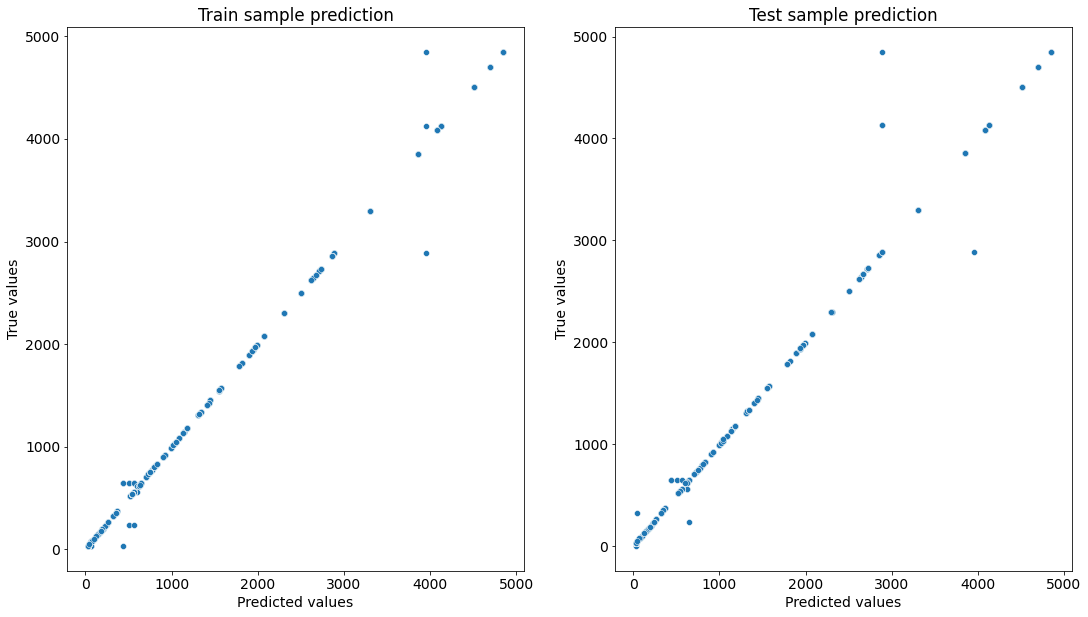

In [ ]:
fix_hc_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=13,
                                 min_samples_leaf=3, 
                                 random_state=42)
fix_hc_model.fit(X_hc_train, y_hc_train)

y_hc_train_preds = fix_hc_model.predict(X_hc_train)
y_hc_test_preds = fix_hc_model.predict(X_hc_test)
evaluate_preds(y_hc_train, y_hc_train_preds, y_hc_test, y_hc_test_preds)

In [ ]:
# Fill gaps
y_hc_predicted = fix_hc_model.predict(df_predict_hc)
train_df.loc[train_df['Healthcare_1_nan'] == 1, 'Healthcare_1'] = y_hc_predicted
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             10000 non-null  int64  
 1   DistrictId                     10000 non-null  int64  
 2   Rooms                          10000 non-null  float64
 3   Square                         10000 non-null  float64
 4   LifeSquare                     10000 non-null  float64
 5   KitchenSquare                  10000 non-null  float64
 6   Floor                          10000 non-null  float64
 7   HouseFloor                     10000 non-null  float64
 8   HouseYear                      10000 non-null  int64  
 9   Ecology_1                      10000 non-null  float64
 10  Ecology_2                      10000 non-null  int64  
 11  Ecology_3                      10000 non-null  int64  
 12  Social_1                       10000 non-null  

In [ ]:
class FixHealthcare_1():
    
    def __init__(self):
        self.fix_hc_model = None
        self.feature_names_hc = None
        
    def fit(self, X):
        self.feature_names_hc = ['med_square_per_dist', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                                 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 
                                 'Helthcare_2', 'Shops_1', 'Ecology_2', 'Ecology_3', 'Shops_2']
        
        df_have_hc = X.loc[X['Healthcare_1_nan'] == 0]
        df_predict_hc = X.loc[X['Healthcare_1_nan'] == 1]
        
        
        X_hc = df_have_hc.drop(columns='Healthcare_1')
        y_hc = df_have_hc['Healthcare_1']
        
        X_hc_train, X_hc_test, y_hc_train, y_hc_test = train_test_split(X_hc, y_hc, test_size=0.3, 
                                                                shuffle=True, random_state=100, )
        
        X_hc_train = X_hc_train[self.feature_names_hc]
        
        self.fix_hc_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=13,
                                 min_samples_leaf=3, 
                                 random_state=42)
        self.fix_hc_model.fit(X_hc_train, y_hc_train)
        
    def transform(self, X):
        df_predict_hc = X.loc[X['Healthcare_1_nan'] == 1]
        
        X.loc[X['Healthcare_1_nan'] == 1, 'Healthcare_1'] = \
                self.fix_hc_model.predict(df_predict_hc[self.feature_names_hc])
        
        return X


# <center> Generate new features </center> <a class='anchor' id='5'>

### New Features <a class='anchor' id='5.1'>

In [ ]:
# Low floor or not. Low floor below 20% of the building
train_df['Low_floor'] = 0
train_df.loc[(train_df['Floor'] <= train_df['HouseFloor']*0.2), 'Low_floor'] = 1

# High floor or not. High floor above 80% of the building
train_df['High_floor'] = 0
train_df.loc[(train_df['Floor'] > train_df['HouseFloor'] * 0.8), 'High_floor'] = 1

# Soviet Union house
train_df['Soviet_house'] = 0
train_df.loc[(train_df['HouseYear'] >= 1991), 'Soviet_house'] = 1

# District size - number of apartments in the disctrict
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')

# Is district big
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [ ]:
# Convert HouseYear and HouseFloor to categories
def floor_to_cat(DF):
    bins = [DF['Floor'].min(), 3, 5, 9, 15, DF['Floor'].max()]
    DF['floor_cat'] = pd.cut(DF['Floor'], bins=bins, labels=False)
    
    DF['floor_cat'].fillna(-1, inplace=True)
    return DF

def year_to_cat(DF):
    bins = [DF['HouseYear'].min(), 1945, 1950, 1991, 2000, 2010, DF['HouseYear'].max()]
    DF['year_cat'] = pd.cut(DF['HouseYear'], bins=bins, labels=False)
    
    DF['year_cat'].fillna(-1, inplace=True)
    return DF

In [ ]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)

# Meadian price by year_cat and floor_cat
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False)\
    .agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')

# Mean price by district
mean_price_by_dist = train_df.groupby('DistrictId', as_index=False).agg({'Price':'mean'})\
    .rename(columns={'Price': 'Mean_price_per_dist'})
train_df = train_df.merge(mean_price_by_dist, on='DistrictId', how='left')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             10000 non-null  int64  
 1   DistrictId                     10000 non-null  int64  
 2   Rooms                          10000 non-null  float64
 3   Square                         10000 non-null  float64
 4   LifeSquare                     10000 non-null  float64
 5   KitchenSquare                  10000 non-null  float64
 6   Floor                          10000 non-null  float64
 7   HouseFloor                     10000 non-null  float64
 8   HouseYear                      10000 non-null  int64  
 9   Ecology_1                      10000 non-null  float64
 10  Ecology_2                      10000 non-null  int64  
 11  Ecology_3                      10000 non-null  int64  
 12  Social_1                       10000 non-null  

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'med_price_per_dist'})
            
            self.med_price_by_district_median = self.med_price_by_district['med_price_per_dist'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'med_price_per_floor_and_year'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['med_price_per_floor_and_year'].median()
        

        
    def transform(self, X):
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + floor_cat row
        X = self.year_to_cat(X)   # +  year_cat row
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            X['med_price_per_dist'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['med_price_per_floor_and_year'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        # Low floor
        X['Low_floor'] = 0
        X.loc[(X['Floor'] <= X['HouseFloor']*0.2), 'Low_floor'] = 1

        # High floor
        X['High_floor'] = 0
        X.loc[(X['Floor'] > X['HouseFloor'] * 0.8), 'High_floor'] = 1
        
        # Soviet Union house
        X['Soviet_house'] = 0
        X.loc[(X['HouseYear'] >= 1991), 'Soviet_house'] = 1
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1945, 1950, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 4. Dimension Reduction <a class='anchor' id='5.2'>

In [ ]:
feature_names_corr = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
         'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
         'Shops_2', 'DistrictSize', 'Low_floor', 'High_floor']

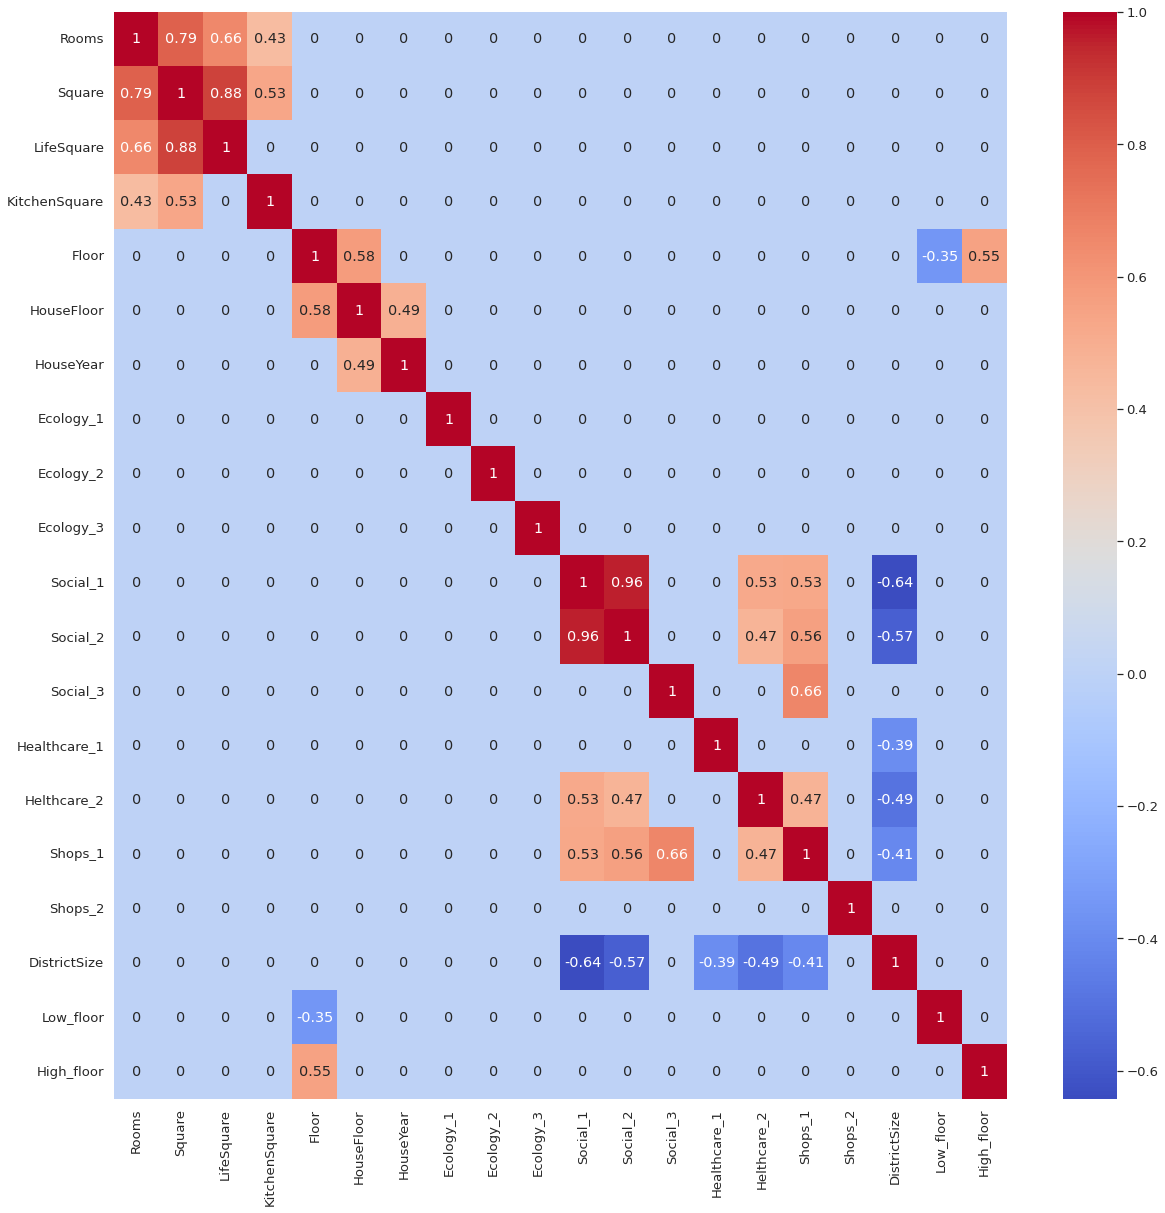

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(20,20))
corr_matrix = train_df[feature_names_corr].corr()
corr_matrix = np.round(corr_matrix, 3)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

There is a strong correlation between Social_1 Social_2 

In [ ]:
scaler_for_social = RobustScaler()
colnames= ['Social_1', 'Social_2']
social_scaled = pd.DataFrame(scaler_for_social.fit_transform(train_df[colnames]), columns=colnames)

In [ ]:
dim_reducer_social, component_social = reduce_dims(social_scaled, dims=1, method='pca')
component_social.head(2)

,component_1
0,-0.60
1,0.23


In [ ]:
dim_reducer_social.explained_variance_ratio_

array([0.97879668])

The component explains 98% of the data

In [ ]:
train_df['Social_comp'] = component_social

There is a strong correlation between Rooms, Square and LifeSquare as well

In [ ]:
scaler_for_square = RobustScaler()
colnames= ['Rooms', 'Square', 'LifeSquare']
square_scaled = pd.DataFrame(scaler_for_square.fit_transform(train_df[colnames]), columns=colnames)

In [ ]:
dim_reducer_squares, component_squares = reduce_dims(square_scaled, dims=1, method='pca')
component_squares.head(2)

,component_1
0,3.59
1,-1.35


In [ ]:
dim_reducer_squares.explained_variance_ratio_

array([0.85148829])

The component explains 85% of the data. But given that Square is one of the most important feature in prediction, the loss of 15% of the data can greatly affect the prediction. The component can be used when clustering data

In [ ]:
train_df['Square_comp'] = component_squares

In [ ]:
class DimensionReduction():
    
    def __init__(self):
        self.scaler_for_social = None
        self.scaler_for_squares = None
        self.social_colnames = None
        self.squares_colnames = None
        
    def fit(self, X):
        self.scaler_for_social = RobustScaler()
        self.social_colnames= ['Social_1', 'Social_2']
        self.scaler_for_social.fit(X[self.social_colnames])
        
        self.scaler_for_squares = RobustScaler()
        self.squares_colnames = ['Rooms', 'Square', 'LifeSquare']
        self.scaler_for_squares.fit(X[self.squares_colnames])
        
    def transform(self, X):
        social_scaled = pd.DataFrame(self.scaler_for_social.transform(X[self.social_colnames]), \
                                     columns=self.social_colnames)
        dim_reducer_social, component_social = reduce_dims(social_scaled, dims=1, method='pca')
        
        X['Social_comp'] = component_social
        
        square_scaled = pd.DataFrame(self.scaler_for_squares.transform(X[self.squares_colnames]), \
                                     columns=self.squares_colnames)
        dim_reducer_squares, component_squares = reduce_dims(square_scaled, dims=1, method='pca')
        X['Square_comp'] = component_squares
        
        return X

# <center> Feature selection </center> <a class='anchor' id='6'>

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseYear_outlier',
 'HouseFloor_outlier',
 'med_house_floor_per_dist',
 'med_house_floor_per_year',
 'Floor_outlier',
 'Square_outlier',
 'med_square_per_dist',
 'med_square_per_year',
 'med_square_per_dist_and_rooms',
 'med_square_per_year_and_rooms',
 'ProcentOfLifeSquare',
 'Rooms_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'Low_floor',
 'High_floor',
 'Soviet_house',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'Mean_price_per_dist',
 'Social_comp',
 'Square_comp']

In [ ]:
# feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#      'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
#      'Shops_1', 'Shops_2',]

# new_feature_names = ['LifeSquare_nan', 'Healthcare_1_nan','HouseYear_outlier','HouseFloor_outlier',
#     'Floor_outlier', 'Rooms_outlier', 'Square_outlier', 'KitchenSquare_outlier', 'LifeSquare_outlier',
#      'med_house_floor_per_dist', 'med_house_floor_per_year', 'med_square_per_dist', 'med_square_per_year',
#      'med_square_per_dist_and_rooms', 'med_square_per_year_and_rooms', 'ProcentOfLifeSquare', 'Low_floor',
#      'Soviet_house', 'DistrictSize', 'IsDistrictLarge', 'year_cat', 'floor_cat', 'MedPriceByFloorYear',
#      'Mean_price_per_dist', 'High_floor', 'Social_comp', 'Square_comp']
# target_name = 'Price'

In [ ]:
feature_names_total = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                       'HouseYear', 'year_cat', 'Ecology_1', 'Social_comp', 'Social_3', 'Healthcare_1',
                       'Helthcare_2', 'Shops_1', 'Shops_2', 'med_price_per_dist',  'IsDistrictLarge', 
                       'DistrictSize', 'floor_cat', 'Soviet_house','Low_floor', 
                       'med_price_per_floor_and_year', 'Square_comp']
feature_names_for_model = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                           'HouseYear', 'Ecology_1', 'Social_comp', 'Social_3', 'Helthcare_2', 'Shops_1', 'med_price_per_dist', 
                            'Healthcare_1', 'Shops_2', 'IsDistrictLarge', 'DistrictSize', 'IsDistrictLarge',
                           'Low_floor', 'med_price_per_floor_and_year']

feature_names_for_cluster = ['Rooms', 'Square_comp', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_comp', 'Social_3', 'Helthcare_2', 'Shops_1', 'med_price_per_dist', 
                 'Healthcare_1', 'Shops_2', 'DistrictSize']

target_name = 'Price'

# <center> Split dataset on train and test </center>  <a class='anchor' id='7'>

In [ ]:
train_df = pd.read_csv(DATASET_PATH, sep=',')
test_df = pd.read_csv(DATASET_PATH_TEST, sep=',')
submit = pd.read_csv(DATASET_SUBMISSION, sep=',')

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train, proc)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [ ]:
fix_healthcare = FixHealthcare_1()
fix_healthcare.fit(X_train)

X_train = fix_healthcare.transform(X_train)
X_valid = fix_healthcare.transform(X_valid)
test_df = fix_healthcare.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 44), (3300, 44), (5000, 44))

In [ ]:
dimension_reduction = DimensionReduction()
dimension_reduction.fit(X_train)
X_train = dimension_reduction.transform(X_train)
X_valid = dimension_reduction.transform(X_valid)
test_df = dimension_reduction.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 46), (3300, 46), (5000, 46))

In [ ]:
X_train = X_train[feature_names_total]
X_valid = X_valid[feature_names_total]
test_df = test_df[feature_names_total]

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# <center> Modeling </center>  <a class='anchor' id='8'>

**Standartization of features**

In [ ]:
feature_names_for_stand = [ 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'Healthcare_1', 
                           'DistrictSize',  'Social_3', 'Shops_1', 'med_price_per_dist', 'med_price_per_floor_and_year']

In [ ]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [ ]:
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
test_df_scaled = test_df.copy()
X_train_scaled[feature_names_for_stand] = stand_features_train
X_valid_scaled[feature_names_for_stand] = stand_features_valid
test_df_scaled[feature_names_for_stand] = stand_features_test

Train R2:	0.894
Test R2:	0.743


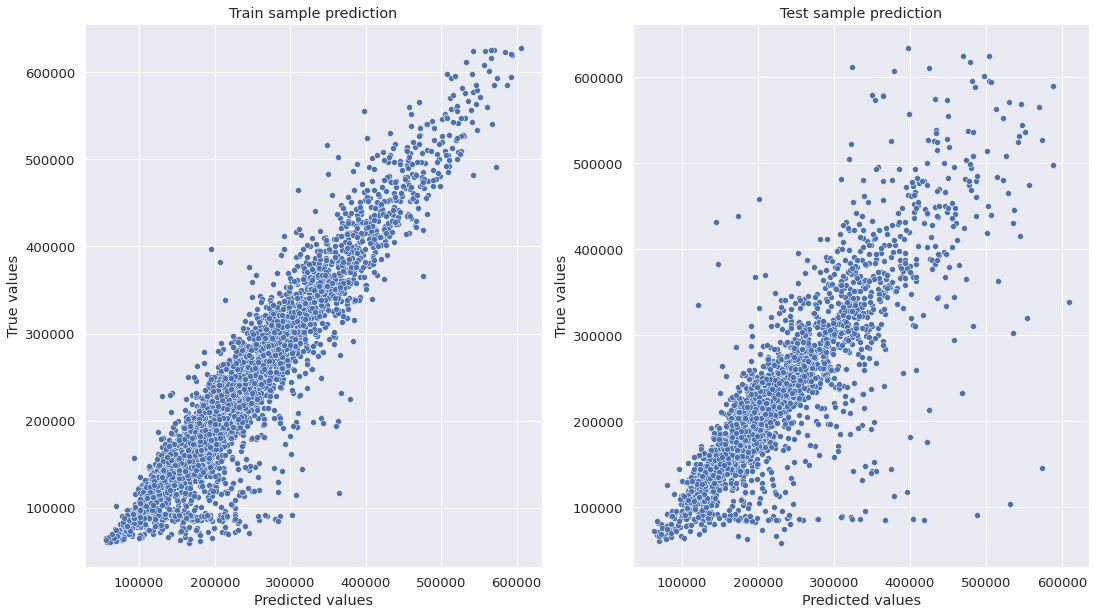

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=27,
                                     random_state=42,
                                     n_estimators=250
                                     )
gb_model.fit(X_train_scaled[feature_names_for_model], y_train)

y_train_preds = gb_model.predict(X_train_scaled[feature_names_for_model])
y_valid_preds = gb_model.predict(X_valid_scaled[feature_names_for_model])
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

LAZY PREDICT  <a class='anchor' id='8.1'>

In [ ]:
clf = LazyRegressor(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     random_state=12)

models, predictions = clf.fit(X_train_scaled , X_valid_scaled , y_train , y_valid)
clear_output()

In [ ]:
models[:15]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.74,0.75,47159.93,0.36
HistGradientBoostingRegressor,0.74,0.74,47743.44,1.30
ExtraTreesRegressor,0.74,0.74,47844.56,5.05
RandomForestRegressor,0.73,0.73,48304.62,6.69
XGBRegressor,0.72,0.73,49000.94,1.17
GradientBoostingRegressor,0.72,0.72,49401.80,2.87
BaggingRegressor,0.71,0.71,50566.09,1.01
KNeighborsRegressor,0.66,0.66,54419.33,0.70
BayesianRidge,0.65,0.65,55406.68,0.07


Train R2:	0.888
Test R2:	0.744


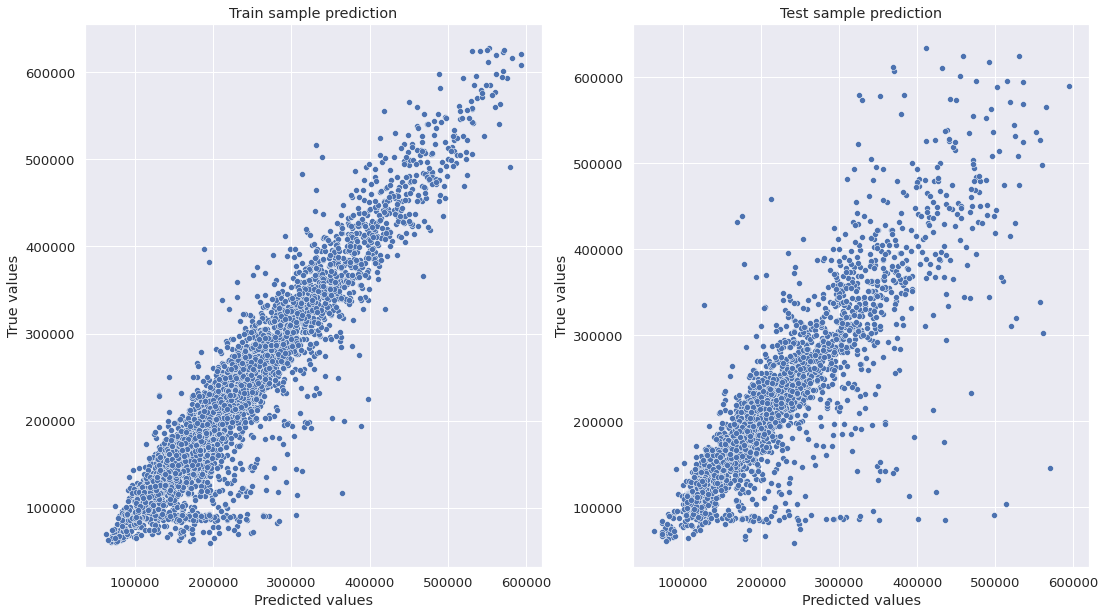

In [ ]:
model = LGBMRegressor(random_state=42, 
                      n_estimators=150,
                      max_depth=14, 
                      num_leaves=24,
                      boosting_type='gbdt'
                      )
model.fit(X_train_scaled, y_train)
y_train_preds = model.predict(X_train_scaled)
y_valid_preds = model.predict(X_valid_scaled)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

# <center> Clusterization </center> <a class='anchor' id='9'>

In [ ]:
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled[feature_names_for_cluster], dims=2, method='tsne', perplexity=50)

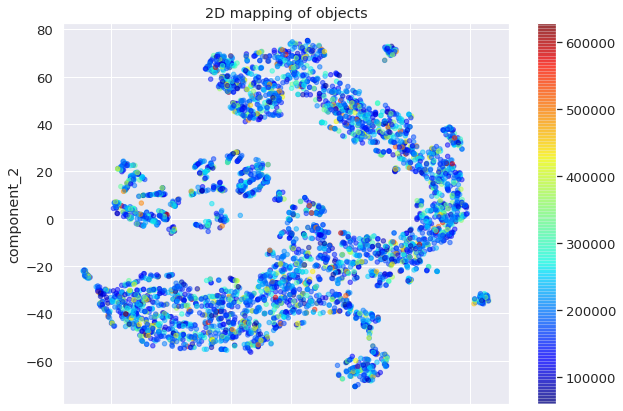

In [ ]:
display_components_in_2D_space(components_2d_tsne, y_train)

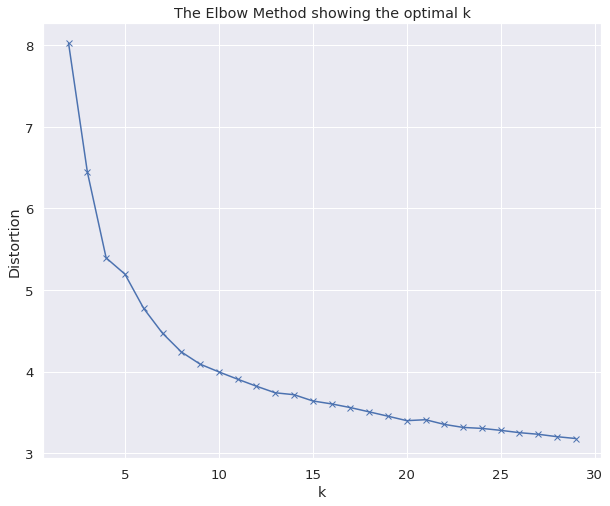

In [ ]:
apply_elbow_method(X_train_scaled)

Recommended number of clusters is 4

### AgglomerativeClustering <a class='anchor' id='9.1'>

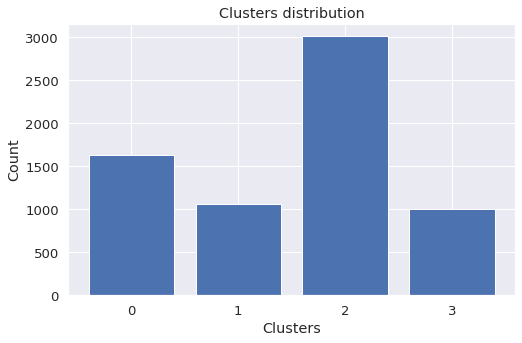

In [ ]:
aggl = AgglomerativeClustering(n_clusters=4)
labels_clast = aggl.fit_predict(X_train_scaled[feature_names_for_cluster])
labels_clast = pd.Series(labels_clast, name='clusters_aggl')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled[feature_names_for_cluster], labels_clast)

labels_clast_valid = knn.predict(X_valid_scaled[feature_names_for_cluster])
labels_clast_test = knn.predict(test_df_scaled[feature_names_for_cluster])

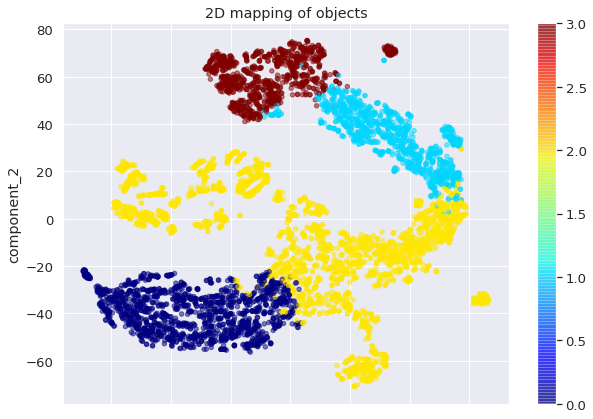

In [ ]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

In [ ]:
clusters_aggl_dummies = pd.get_dummies(labels_clast, prefix='clusters_4_aggl')
clusters_aggl_dummies.index = X_train_scaled.index
X_train_cluster_aggl = pd.concat([X_train_scaled, clusters_aggl_dummies], axis=1)

clusters_aggl_dummies_valid = pd.get_dummies(labels_clast_valid, prefix='clusters_4_aggl')
clusters_aggl_dummies_valid.index = X_valid_scaled.index
X_valid_cluster_aggl = pd.concat([X_valid_scaled, clusters_aggl_dummies_valid], axis=1)

clusters_aggl_dummies_test = pd.get_dummies(labels_clast_test, prefix='clusters_4_aggl')
clusters_aggl_dummies_test.index = test_df_scaled.index
test_df_cluster_aggl = pd.concat([test_df_scaled, clusters_aggl_dummies_test], axis=1)

### Modeling and comparing <a class='anchor' id='9.1'>

Train R2:	0.888
Test R2:	0.747


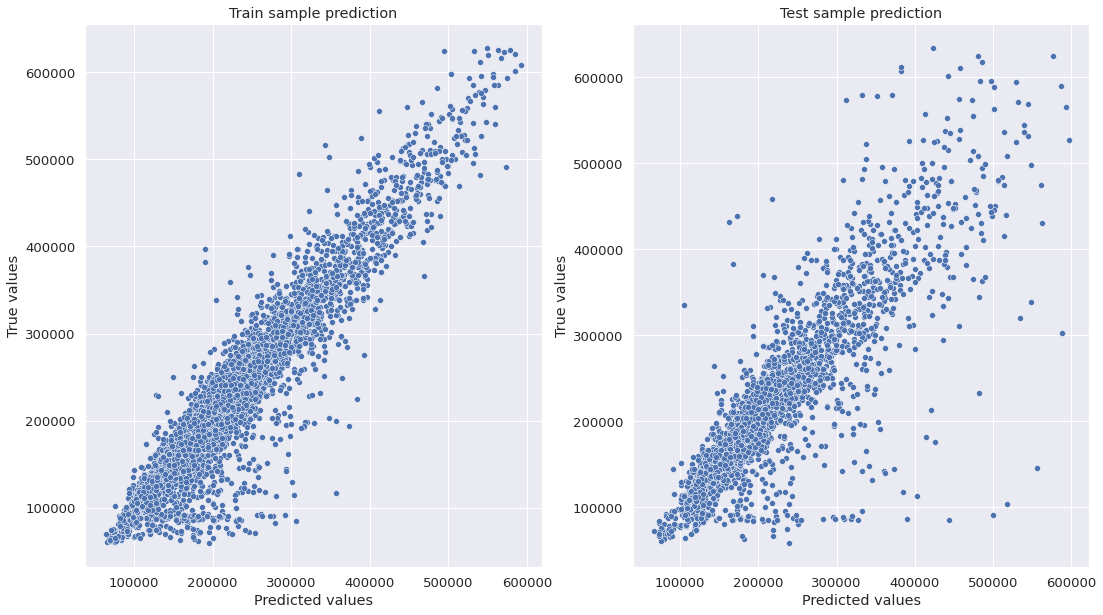

In [ ]:
model_2 = LGBMRegressor(random_state=42, 
                      n_estimators=150,
                      max_depth=14, 
                      num_leaves=24,
                      boosting_type='gbdt'
                      )
model_2.fit(X_train_cluster_aggl, y_train)
y_train_preds = model_2.predict(X_train_cluster_aggl)
y_valid_preds = model_2.predict(X_valid_cluster_aggl)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

R2 of model_2 is higher then model 

**Cross validation**

In [ ]:
cv_score = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74778094, 0.70676633, 0.73817524])

In [ ]:
cv_score = cross_val_score(model_2, X_train_cluster_aggl, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74605755, 0.70977877, 0.73811702])

**Feature importances**

In [ ]:
feature_importances = pd.DataFrame(zip(X_train_cluster_aggl.columns, model_2.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,390
15,med_price_per_dist,337
6,HouseYear,301
22,Square_comp,295
2,LifeSquare,294
17,DistrictSize,211
9,Social_comp,211
21,med_price_per_floor_and_year,196
8,Ecology_1,194
4,Floor,184


# <center> Prediction and submission </center> <a class='anchor' id='10'>

In [ ]:
submit.head()

,Id,Price
0,4567,200000.00
1,5925,200000.00
2,960,200000.00
3,3848,200000.00
4,746,200000.00


In [ ]:
predictions = model_2.predict(test_df_cluster_aggl)
predictions

array([162148.13762998, 124448.46237061, 147938.21356927, ...,
       145281.3961864 , 195235.41180426, 273916.44810054])

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162148.14
1,5925,124448.46
2,960,147938.21
3,3848,128408.76
4,746,180034.37


**Save model and predicted file**

In [ ]:
MODEL_PATH = '/gdrive/My Drive/Files/models/'

In [ ]:
with open(MODEL_PATH + 'LGBM_model_predict_price_of_apartment.pkl', 'wb') as file:
    pickle.dump(model_2, file)

In [ ]:
submit.to_csv('/gdrive/My Drive/Files/LGBM_submit.csv', index=False)